In [541]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [542]:
df= pd.read_csv(r'C:\Users\moniq\Downloads\Datascience\primera entrega\fraud_oracle.csv', sep=';')

Este dataset de 15420 datos proporciona la siguiente información:

00) Month: mes en el que ocurrió el accidente

01) WeekOfMonth: semana en la que ocurrió el accidente

02) DayOfWeek: Día de la semana en que ocurrió el accidente

03) Make: Marca del vehículo

04) AccidentArea: Si el accidente fue en un área rural o urbana

05) DayOfWeekClaimed: Día de la semana en la que se hizo la denuncia

06) MonthClaimed: Mes en el que se hizo la denuncia

07) WeekOfMonthClaimed: Número de semana del mes en la que se hizo la denuncia

08) Sex: Género de la persona que realiza la denuncia

09) MaritalStatus: Estado cívil de la persona que hace la denuncia

10) Age: Edad de la persona que hace la denuncia

11) Fault: Si el culpable fue el dueño del seguro u otro involucrado

12) PolicyType: Combinación de tipo de auto y de tipo de póliza: Liability (contra terceros), Collision (Incluye daños al vehículo del propietario), All Perils (contra todo riesgo)

13) VehicleCatergory: Clasificación de tipo de auto

14) VehiclePrice: Precio del vehículo

15) FraudFound_P: Si el incidente fue fraudulento o no, columna a predecir

16) PolicyNumber: Número único de accidente, coincide con el número de filas del dataset

17) RepNumber: Numeración entre 1 y 16

18) Deductible: Costo del seguro

19) DriverRating: Calificación del piloto, puede ser data ordinal

20) Days_Policy_Accident: Rango adquisición del seguro y suceso del accidente

21) Days_Policy_Claim: Rango entre adquisición del seguro y denuncia del accidente

22) PastNumberOfClaims: Cantidad de denuncias anteriores realizadas por el dueño del vehículo

23) AgeOfVehicle: Edad del vehículo

24) AgeOfPolicyHolder: Edad del dueño del seguro

25) PoliceReportFiled: Si fue denunciado a la policía

26) WitnessPresent: Si hubo un testigo presente

27) AgentType: Internos son cuando el fraude es realizado por personas trabajando en la empresa de seguros. Externos son los fraudes en los que el seguro es engañado por personas independientes.

28) NumberOfSuppliments: Son daños al vehículo no registrados a la hora de la denuncia, daños extras que no se ven por el exterior, normalmente roturas en componentes internos como suspensión, chasis, etc

29) AddressChange_Claim: Si el dueño del seguro se mudó después de denunciar un accidente y cuanto tiempo después

30) NumberOfCars: Número de autos involucrados en el accidente

31) Year: Año en el que ocurrió el accidente

32) BasePolicy: Tipo de seguro

***Limpieza de datos***

Divideremos el proceso de limpieza de datos por dos secciones: eliminado de duplicados y tratamiento a datos nulos.

**Datos NaN**

In [543]:
df = df.dropna()

**Datos duplicados**

In [544]:
df = df.drop_duplicates()


**Análisis y tratamiento de datos nulos** 

Text(0.5, 1.0, 'Matrix de valores nulos')

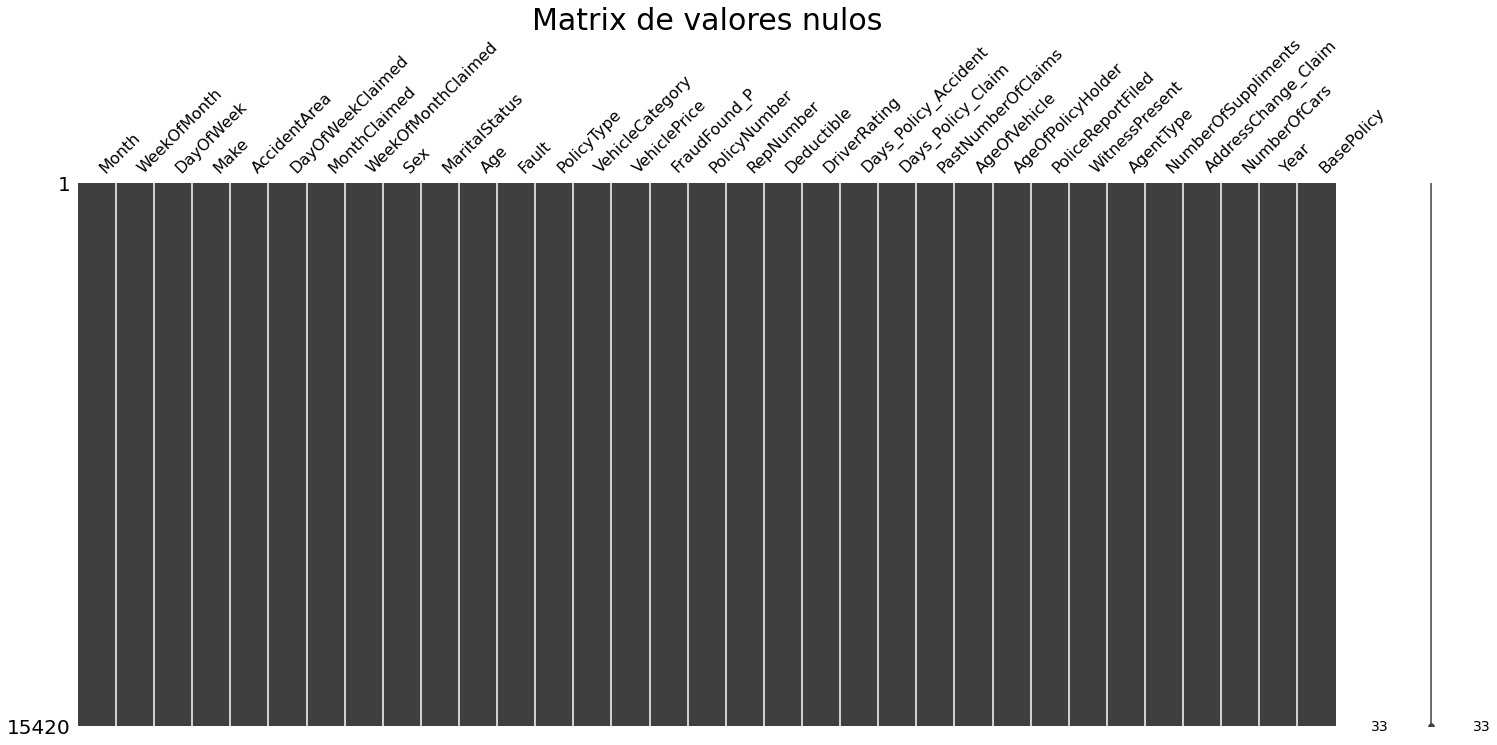

In [545]:
msno.matrix(df)
plt.title("Matrix de valores nulos",fontsize=30)

Tanto la matrix como el método .info() nos indica que no contamos con ninguna fila que contenga datos nulos.

Se procederá a analizar a través de los siguientes histogramas y el análisis de valores únicos de cada variable para identificar presencia de datos outliers o incoherentes. De haberlos, se le aplicará el tratamiento correspondiente.

In [546]:
#for column in df:
#    print(column)
#    print(sorted(df[column].unique()),"\n")

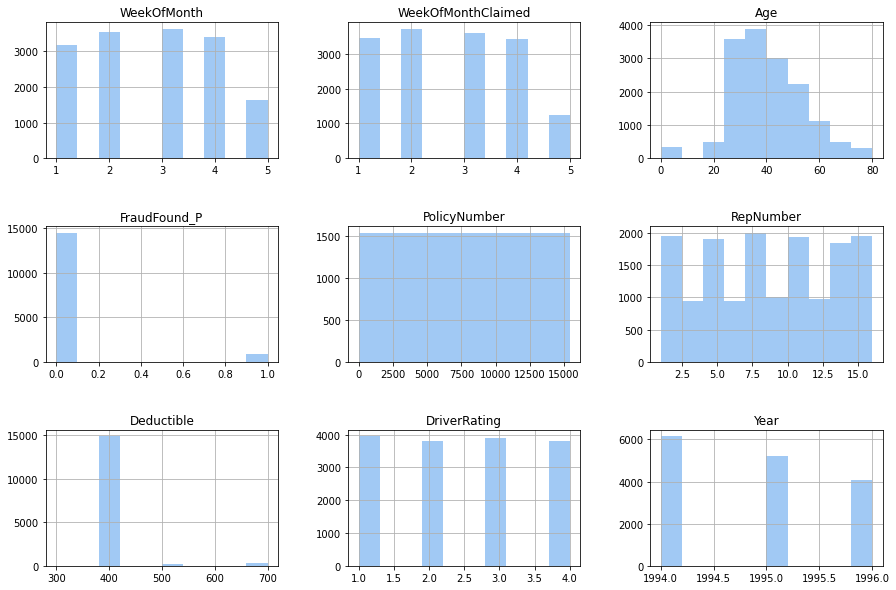

In [547]:
sns.set_palette("pastel")
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

Se analizarán los 0 presentados en Age, DayOfWeekClaimed y MonthClaimed. Se analiza primero la variable edad.

In [548]:
df_age_0 = df.loc[(df['Age'] == 0)]

In [549]:
df_age_0.AgeOfPolicyHolder.value_counts()

16 to 17    320
Name: AgeOfPolicyHolder, dtype: int64

Como todos los casos con Age=0 indica que el AgeOfPolicyHolder se encuentra entre el rango de los 16-17años, reemplazo la edad por 17

In [550]:
df['Age'] = df['Age'].replace(0, 17)

Creo una nueva variable "Age_coherent" para analizar si hay más casos inconsistentes entre las variables "Age" y "AgeOfPolicyHolder". 

In [551]:
df['AgeOfPolicyHolder'] = df['AgeOfPolicyHolder'].replace("over 65", "66 to 110")

In [552]:
df["Age_coherent"] = df.apply(lambda x: True if int(x["Age"]) in range(int(x["AgeOfPolicyHolder"].split("to")[0]), int(x["AgeOfPolicyHolder"].split("to")[1])+1) else False, axis=1)

In [553]:
df[['start_age', 'end_age']] = df['AgeOfPolicyHolder'].str.split(' to ', expand=True).astype(int)
df['age_mean'] = (df['start_age'] + df['end_age']) / 2

In [554]:
df.loc[df['Age'] < df['start_age'], 'Age'] = df['age_mean']

In [555]:
df.loc[df['Age'] > df['end_age'], 'Age'] = df['age_mean']

Analizo DayOfWeekClaimed y MonthClaimed.

In [556]:
#len(df.loc[df['DayOfWeekClaimed'] == '0'])
#len(df.loc[df['MonthClaimed'] == '0'])

Remuevo estas el entry donde DayOfWeekClaimed= 0 y MonthClaimed= 0 ya que no tengo otras variables de la cual pueda utilizar para interpolarlas.

In [557]:
df.drop(df[df['DayOfWeekClaimed'] == '0'].index)
df.drop(df[df['MonthClaimed'] == '0'].index)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,Age_coherent,start_age,end_age,age_mean
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,External,none,1 year,3 to 4,1994,Liability,False,26,30,28.0
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,External,none,no change,1 vehicle,1994,Collision,True,31,35,33.0
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,External,none,no change,1 vehicle,1994,Collision,True,41,50,45.5
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,External,more than 5,no change,1 vehicle,1994,Liability,True,51,65,58.0
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,External,none,no change,1 vehicle,1994,Collision,False,31,35,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,External,none,no change,1 vehicle,1996,Collision,True,31,35,33.0
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,External,more than 5,no change,3 to 4,1996,Liability,False,31,35,33.0
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,External,1 to 2,no change,1 vehicle,1996,Collision,False,26,30,28.0
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,External,more than 5,no change,1 vehicle,1996,All Perils,True,31,35,33.0


Remuevo variables creadas para remediar la variable Age

In [558]:
df_cleaned = df.copy().drop(['Age_coherent','start_age','end_age','age_mean'], axis=1)

Normalizo los valores

In [559]:
df_cleaned=df_cleaned.rename(columns={'FraudFound_P': 'FraudFoundP', 'Days_Policy_Accident':'DaysPolicyAccident','Days_Policy_Claim':'DaysPolicyClaim','AddressChange_Claim':'AddressChangeClaim'})

In [560]:
df_cleaned['Age'] = df_cleaned['Age'].astype('int')

**Preprocesamiento**

Tratamiento de variables categóricas

In [561]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Brand = le.fit_transform(df['Make'])

df_cleaned.drop("Make", axis=1, inplace=True)
df_cleaned["Make"] = Brand

In [562]:
df_cleaned["Month"] = le.fit_transform(df_cleaned["Month"])
df_cleaned["DayOfWeek"] = le.fit_transform(df_cleaned["DayOfWeek"])
df_cleaned["DayOfWeekClaimed"] = le.fit_transform(df_cleaned["DayOfWeekClaimed"])
df_cleaned["MonthClaimed"] = le.fit_transform(df_cleaned["MonthClaimed"])
df_cleaned["PolicyType"] = le.fit_transform(df_cleaned["PolicyType"])
df_cleaned["VehiclePrice"] = le.fit_transform(df_cleaned["VehiclePrice"])
df_cleaned["DaysPolicyAccident"] = le.fit_transform(df_cleaned["DaysPolicyAccident"])
df_cleaned["PoliceReportFiled"] = le.fit_transform(df_cleaned["PoliceReportFiled"])
df_cleaned["WitnessPresent"] = le.fit_transform(df_cleaned["WitnessPresent"])
df_cleaned["AgentType"] = le.fit_transform(df_cleaned["AgentType"])
df_cleaned["NumberOfSuppliments"] = le.fit_transform(df_cleaned["NumberOfSuppliments"])
df_cleaned["AgentType"] = le.fit_transform(df_cleaned["AgentType"])
df_cleaned["PastNumberOfClaims"] = le.fit_transform(df_cleaned["PastNumberOfClaims"])
df_cleaned["AgeOfVehicle"] = le.fit_transform(df_cleaned["AgeOfVehicle"])
df_cleaned["AgeOfPolicyHolder"] = le.fit_transform(df_cleaned["AgeOfPolicyHolder"])
df_cleaned["AddressChangeClaim"] = le.fit_transform(df_cleaned["AddressChangeClaim"])
df_cleaned["NumberOfCars"] = le.fit_transform(df_cleaned["NumberOfCars"])
df_cleaned["BasePolicy"] = le.fit_transform(df_cleaned["BasePolicy"])
df_cleaned["DaysPolicyClaim"] = le.fit_transform(df_cleaned["DaysPolicyClaim"])

In [563]:
#Aplico one hot enconding para las variables que no cuenten con muchos +4 valores únicos para evitar aumentar la dimensionalidad del conjunto de datos.

pd.get_dummies(df_cleaned, columns=['Sex', 'MaritalStatus', 'AccidentArea','Fault','VehicleCategory'])
pd.get_dummies(df_cleaned, columns=['Sex', 'MaritalStatus', 'AccidentArea','Fault','VehicleCategory'], drop_first=True)
df_cleaned = pd.get_dummies(df_cleaned, columns=['Sex', 'MaritalStatus', 'AccidentArea', 'Fault', 'VehicleCategory'])

**Método RFECV para feature selection**

In [564]:
X = df_cleaned.drop("FraudFoundP", 1)

y = df_cleaned['FraudFoundP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

C:\Users\moniq\AppData\Local\Temp/ipykernel_4616/3264589968.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_cleaned.drop("FraudFoundP", 1)


In [565]:
model = RandomForestClassifier(n_estimators= 10, random_state=9700)
rfecv = RFECV(estimator= model, step = 3, cv = 3,scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)

print("The optimal number of features:", rfecv.n_features_)
print("Best features:", X_train.columns[rfecv.support_])

The optimal number of features: 25
Best features: Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed',
       'WeekOfMonthClaimed', 'Age', 'PolicyType', 'VehiclePrice',
       'PolicyNumber', 'RepNumber', 'DriverRating', 'PastNumberOfClaims',
       'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments',
       'AddressChangeClaim', 'NumberOfCars', 'Year', 'BasePolicy', 'Make',
       'MaritalStatus_Married', 'AccidentArea_Rural', 'Fault_Policy Holder',
       'Fault_Third Party'],
      dtype='object')


In [566]:
#Remuevo variables no revelantes.
columns_to_keep = ['Month', 'WeekOfMonth', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed',
       'WeekOfMonthClaimed', 'Age', 'PolicyType', 'VehiclePrice',
       'PolicyNumber', 'RepNumber', 'DriverRating', 'PastNumberOfClaims',
       'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments',
       'AddressChangeClaim', 'NumberOfCars', 'Year', 'BasePolicy', 'Make',
       'MaritalStatus_Married', 'AccidentArea_Rural', 'Fault_Policy Holder',
       'Fault_Third Party']
df_cleaned = df_cleaned.copy().drop(df_cleaned.columns.difference(columns_to_keep), axis=1)


**Modelos de clasificación**

Decision Tree Classifier

In [567]:
dtc = DecisionTreeClassifier(max_depth=4)

dtc = dtc.fit(X_train,y_train)

y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

In [568]:
dtc_accuracy_test= metrics.accuracy_score(y_test,y_test_pred)
dtc_accuracy_train=metrics.accuracy_score(y_train,y_train_pred)
dtc_precision= precision_score(y_test, y_test_pred) 
dtc_recall=recall_score(y_test, y_test_pred) 
dtc_F1=f1_score(y_test, y_test_pred) 

print(dtc_accuracy_test)
print(dtc_accuracy_train)
print(dtc_precision)
print(dtc_recall)
print(dtc_F1)

0.933852140077821
0.943174448767834
0.5333333333333333
0.03902439024390244
0.07272727272727272


Gradient Boosting Classifier

In [570]:
from sklearn.ensemble import GradientBoostingClassifier

In [571]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)


gbc = clf.fit(X_train,y_train)


y_train_pred = gbc.predict(X_train)
y_test_pred = gbc.predict(X_test)

In [572]:
gbc_accuracy_test= metrics.accuracy_score(y_test,y_test_pred)
gbc_accuracy_train=metrics.accuracy_score(y_train,y_train_pred)
gbc_precision= precision_score(y_test, y_test_pred) 
gbc_recall=recall_score(y_test, y_test_pred) 
gbc_F1=f1_score(y_test, y_test_pred) 

print(gbc_accuracy_test)
print(gbc_accuracy_train)
print(gbc_precision)
print(gbc_recall)
print(gbc_F1)

0.933852140077821
0.9418774319066148
1.0
0.004878048780487805
0.009708737864077669


AdaBoost Classifier

In [574]:
from sklearn.ensemble import AdaBoostClassifier

In [575]:
abc = AdaBoostClassifier(n_estimators=100, random_state=0)


abc = abc.fit(X_train,y_train)


y_train_pred = abc.predict(X_train)
y_test_pred = abc.predict(X_test)

In [576]:
abc_accuracy_test= metrics.accuracy_score(y_test,y_test_pred)
abc_accuracy_train= metrics.accuracy_score(y_train,y_train_pred)
abc_precision= precision_score(y_test, y_test_pred) 
abc_recall=recall_score(y_test, y_test_pred) 
abc_F1=f1_score(y_test, y_test_pred) 

print(abc_accuracy_test)
print(abc_accuracy_train)
print(abc_precision)
print(abc_recall)
print(abc_F1)

0.9286640726329443
0.9386348897535668
0.2413793103448276
0.03414634146341464
0.05982905982905984


Comparación de modelos

In [578]:
comparacion_accuracy = pd.DataFrame({'Modelo': ['Decision Tree Classifier', 'Gradient Boosting Classifier', 'AdaBoost Classifier'], 
                            'Accuracy train': [dtc_accuracy_train,gbc_accuracy_train,abc_accuracy_train], 
                            'Accuracy test': [dtc_accuracy_test,gbc_accuracy_test,abc_accuracy_test]})

comparacion_accuracy.round()

,Modelo,Accuracy train,Accuracy test
0,Decision Tree Classifier,1.0,1.0
1,Gradient Boosting Classifier,1.0,1.0
2,AdaBoost Classifier,1.0,1.0


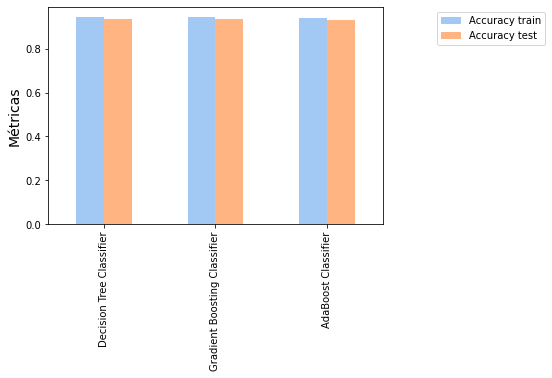

In [587]:
comparacion.plot(x = 'Modelo', kind = 'bar')

plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Métricas', fontsize = 14)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()


In [580]:
comparacion_otras_metricas = pd.DataFrame({'Modelo': ['Decision Tree Classifier', 'Gradient Boosting Classifier', 'AdaBoost Classifier'], 
                            'Precision': [dtc_precision,gbc_precision,abc_precision], 
                            'Recall': [dtc_recall,gbc_recall,abc_recall],
                            'F1 Score': [dtc_F1,gbc_F1,abc_F1]})

comparacion_otras_metricas.round()

,Modelo,Precision,Recall,F1 Score
0,Decision Tree Classifier,1.0,0.0,0.0
1,Gradient Boosting Classifier,1.0,0.0,0.0
2,AdaBoost Classifier,0.0,0.0,0.0


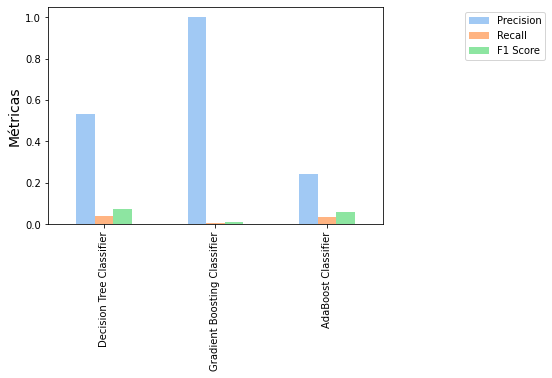

In [588]:
comparacion_otras_metricas.plot(x = 'Modelo', kind = 'bar')

plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Métricas', fontsize = 14)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()